<a href="https://colab.research.google.com/github/Jungkihong07/Deepwave/blob/main/cy_baseLine_code_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 필요 라이브러러 임포트 및 다운로드

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# -------------------------------------------
# 1. 라이브러리 설치 및 임포트
# -------------------------------------------
!pip install umap-learn --quiet
!pip install tensorflow_probability --quiet

import os
import random
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math

# 재현성 설정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


## 데이터 로딩 함수 정의

In [5]:
# -------------------------------------------
# 2. 데이터 로딩 함수 정의
# -------------------------------------------
def load_mfcc_data(audio_path, label_path, max_len=200):
    entries = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                entries.append((parts[1], parts[-1]))
    df = pd.DataFrame(entries, columns=['filename','label'])

    X_list, y_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading MFCC"):
        fp = os.path.join(audio_path, row['filename'])
        if not os.path.isfile(fp):
            continue
        try:
            audio, sr = librosa.load(fp, sr=16000)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).T
            if mfcc.shape[0] < max_len:
                mfcc = np.pad(mfcc, ((0, max_len-mfcc.shape[0]), (0,0)), mode='constant')
            else:
                mfcc = mfcc[:max_len]
            X_list.append(mfcc)
            y_list.append(0 if row['label']=='Real' else 1)
        except:
            continue

    return np.array(X_list), np.array(y_list)


def standardize(X):
    ns, nt, nf = X.shape
    scaler = StandardScaler().fit(X.reshape(-1, nf))
    X_scaled = scaler.transform(X.reshape(-1, nf)).reshape(ns, nt, nf)
    return X_scaled, scaler


### 데이터 셋 캐시 저장
- 사용 예시
save_mfcc_cache(X, y, scaler, cache_prefix="train")
- 사용 조건
  - 목차의 "캐시가 없을 때"를 실행하고 난 후 실행하셔야 합니다.

#### Train set 캐시 저장 함수
- test set을 위한 코드가 아닙니다. train set에만 사용하시기 바랍니다.

In [7]:
def save_mfcc_cache(X, y, scaler, cache_prefix="train"):
    X_cache = f"{cache_prefix}_X.npy"
    y_cache = f"{cache_prefix}_y.npy"
    scaler_cache = f"{cache_prefix}_scaler.npy"

    np.save(X_cache, X)
    np.save(y_cache, y)
    np.save(scaler_cache, {'mean': scaler.mean_, 'scale': scaler.scale_})
    print(f"✅ 캐시 저장 완료: {X_cache}, {y_cache}, {scaler_cache}")
# Train set = > X: 전처리된 입력 특성, y : 정답 레이블, scaler : 표준화 정보
save_mfcc_cache(X, y, scaler, cache_prefix="train")

NameError: name 'X' is not defined

#### Test set 캐시 저장
-  test set을 위한 코드입니다.

In [8]:
prepare_and_cache_test_set(
    audio_path="/content/drive/MyDrive/2501ml_data/test",
    label_path="/content/drive/MyDrive/2501ml_data/label/test_label.txt",
    max_len=200
)

# 1. 훈련 캐시에서 scaler 불러오기
def load_train_scaler(cache_prefix="train"):
    scaler_cache = f"{cache_prefix}_scaler.npy"
    if not os.path.exists(scaler_cache):
        raise FileNotFoundError(f"❌ 스케일러 캐시가 없습니다: {scaler_cache}")
    scaler_params = np.load(scaler_cache, allow_pickle=True).item()

    scaler = StandardScaler()
    scaler.mean_ = scaler_params['mean']
    scaler.scale_ = scaler_params['scale']
    return scaler

# 2. 테스트셋 로딩, 정규화, 캐시 저장
def prepare_and_cache_test_set(audio_path, label_path, max_len=200):
    # (1) load test data
    X_test, y_test = load_mfcc_data(audio_path, label_path, max_len)

    # (2) load scaler from train set
    scaler = load_train_scaler("train")

    # (3) apply scaler to test data
    ns, nt, nf = X_test.shape
    X_test = scaler.transform(X_test.reshape(-1, nf)).reshape(ns, nt, nf)

    # (4) save test data cache
    np.save("test_X.npy", X_test)
    np.save("test_y.npy", y_test)
    print("✅ 테스트셋 캐시 저장 완료")

NameError: name 'prepare_and_cache_test_set' is not defined

### 캐시로부터 MFCC 데이터 로드 함수
- 사용 예시
X, y, scaler = load_mfcc_cache(cache_prefix="train")
- 사용 조건
  - 이후 캐시를 저장하고 난 후는 계속해서 MFCC 데이터 로드 함수를 활용해 이후, 로드할 필요 없이 사용하시면 됩니다.

In [6]:
def load_mfcc_cache(cache_prefix="train"):
    X_cache = f"{cache_prefix}_X.npy"
    y_cache = f"{cache_prefix}_y.npy"
    scaler_cache = f"{cache_prefix}_scaler.npy"

    if not (os.path.exists(X_cache) and os.path.exists(y_cache) and os.path.exists(scaler_cache)):
        raise FileNotFoundError(f"❌ 캐시 파일이 존재하지 않습니다: prefix={cache_prefix}")

    print(f"📂 캐시 불러오는 중: {X_cache}, {y_cache}")
    X = np.load(X_cache)
    y = np.load(y_cache)
    scaler_params = np.load(scaler_cache, allow_pickle=True).item()

    scaler = StandardScaler()
    scaler.mean_ = scaler_params['mean']
    scaler.scale_ = scaler_params['scale']

    return X, y, scaler
# Train set
X, y, scaler = load_mfcc_cache(cache_prefix="train")

FileNotFoundError: ❌ 캐시 파일이 존재하지 않습니다: prefix=train

#### Train set 캐시 로드 함수

#### test set 캐시 로드

In [9]:
# Test set
X_test = np.load("test_X.npy")
y_test = np.load("test_y.npy")
print("✅ 테스트셋 캐시 불러오기 완료")

FileNotFoundError: [Errno 2] No such file or directory: 'test_X.npy'

## DNN 모델 정의

모델 설명:MFCC 시퀀스를 입력으로 받아 Flatten된 시계열 정보와 다양한 통계 요약 피처(mean, std, max, min, median, skewness, kurtosis)를 병합하여 고차원 표현력을 강화한 후, 심층 신경망을 통해 이진 분류를 수행하는걸 목표로 함

**Input shape**: `(time_steps, n_mfcc)`
- **Flatten**: 시계열 정보를 1D 벡터로 펼침
- **통계 피처**:
  - `mean`, `std`, `max`, `min`, `median`: 시간 축 평균 및 분포 정보
  - `skewness`, `kurtosis`: 비대칭성 및 뾰족함(분포의 형태)
- **Concat**: Flatten + 통계 피처 결합 → 최종 입력 벡터 구성

**DNN 구조**:
- `Dense(256)` + `BatchNorm` + `ReLU` + `Dropout(0.3)`  
- `Dense(128)` + `BatchNorm` + `ReLU` + `Dropout(0.3)`  
- `Dense(1, activation='sigmoid')`: 이진 분류 확률 출력


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_probability as tfp

def build_dnn_model(input_shape):
    inputs = layers.Input(shape=input_shape, name="input_mfcc")

    # 기본 피처
    flat = layers.Flatten()(inputs)
    mean = tf.keras.layers.GlobalAveragePooling1D()(inputs)
    std = tf.keras.layers.Lambda(lambda x: tf.math.reduce_std(x, axis=1), output_shape=(input_shape[-1],))(inputs)
    max_ = tf.keras.layers.GlobalMaxPooling1D()(inputs)
    min_ = tf.keras.layers.Lambda(lambda x: tf.reduce_min(x, axis=1), output_shape=(input_shape[-1],))(inputs)
    median = tf.keras.layers.Lambda(lambda x: tfp.stats.percentile(x, 50.0, axis=1), output_shape=(input_shape[-1],))(inputs)
    skew = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean((x - tf.reduce_mean(x, axis=1, keepdims=True)) ** 3, axis=1) /
                  (tf.math.reduce_std(x, axis=1) ** 3 + 1e-6),
        output_shape=(input_shape[-1],))(inputs)
    kurtosis = tf.keras.layers.Lambda(
        lambda x: tf.reduce_mean((x - tf.reduce_mean(x, axis=1, keepdims=True)) ** 4, axis=1) /
                  (tf.math.reduce_std(x, axis=1) ** 4 + 1e-6),
        output_shape=(input_shape[-1],))(inputs)

    features = layers.Concatenate()([flat, mean, std, max_, min_, median, skew, kurtosis])

    x = layers.Dense(256)(features)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    return model


## 학습용 데이터 로딩

In [11]:
train_audio_path = '/content/drive/MyDrive/2501ml_data/train'
train_label_path = '/content/drive/MyDrive/2501ml_data/label/train_label.txt'
max_len = 200

### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.

In [ ]:
X, y = load_mfcc_data(train_audio_path, train_label_path, max_len)
X, scaler = standardize(X)

Loading MFCC:  50%|█████     | 2004/4000 [08:01<07:02,  4.73it/s]

# 모델 학습

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=41
)

model = build_dnn_model(input_shape=(max_len, X.shape[2]))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8827 - loss: 0.3980 - val_accuracy: 0.9837 - val_loss: 0.2805 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9912 - loss: 0.2436 - val_accuracy: 0.9887 - val_loss: 0.2517 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9968 - loss: 0.2315 - val_accuracy: 0.9887 - val_loss: 0.2367 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9976 - loss: 0.2256 - val_accuracy: 0.9900 - val_loss: 0.2249 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9987 - loss: 0.2219 - val_accuracy: 0.9912 - val_loss: 0.2217 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.2184 - val_accuracy: 0.9912 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9988 - loss: 0.2155 -

## 모델 학습 과정 시각화

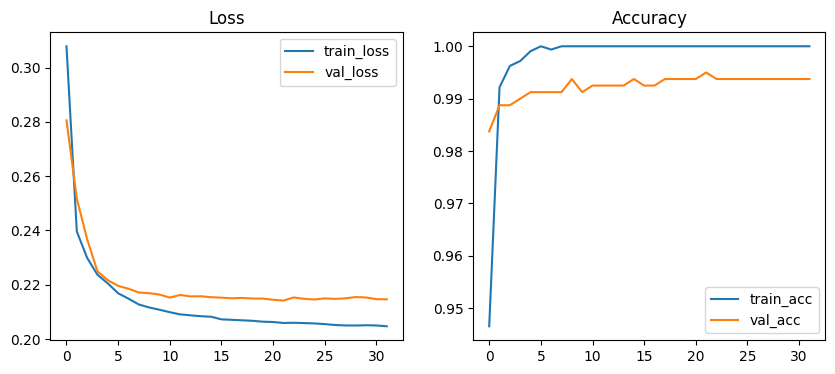

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

plot_history(history)
model.save("dnn_model.h5")

# 테스트 데이터 로딩 및 평가

In [ ]:
test_audio_path = '/content/drive/MyDrive/2501ml_data/test'
test_label_path = '/content/drive/MyDrive/2501ml_data/label/test_label.txt'

### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.
- 캐시를 생성하고 싶다면 목차의 "데이터 셋 캐시 저장"을 실행하시기 바립니다.

In [ ]:
X_test, y_test = load_mfcc_data(test_audio_path, test_label_path, max_len)
ns_test = X_test.shape[0]
X_test, _ = standardize(X_test)

Loading MFCC:  77%|███████▋  | 1539/2000 [00:19<00:04, 99.11it/s]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.84      1.00      0.91      1000
        Fake       1.00      0.81      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.92      0.90      0.90      2000
weighted avg       0.92      0.90      0.90      2000

ROC AUC: 0.912


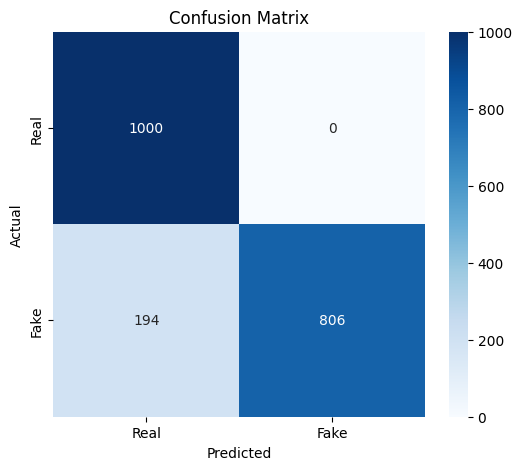

In [ ]:
# -------------------------------------------
# 6. 테스트 데이터 평가
# -------------------------------------------

y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 예측 결과 파일 작성

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. test 파일명 리스트 로딩
def get_test_filenames(label_path):
    filenames = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                filenames.append(parts[1])
    return filenames

# 2. LabelEncoder: Fake → 0, Real → 1
le = LabelEncoder()
le.fit(['Fake', 'Real']) # 반드시 이 순서로 지정해야 0=Fake, 1=Real

# 3. 파일 이름 로드
test_file_names = get_test_filenames(test_label_path)

# 4. 예측 확률 → 클래스 (0 또는 1) => 정규화 방식에 따라 정확도가 차이가 남.
y_pred_prob = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_pred_classes = (y_pred_prob < 0.5).astype(int).flatten()  # 확률 → 0 or 1


# 5. 예측 결과 파일 작성
with open('./test_result.txt', 'w') as f:
    for i in range(len(y_pred_classes)):
        label_str = le.inverse_transform([y_pred_classes[i]])[0]  # 0 → Fake, 1 → Real
        f.write(f"{test_file_names[i]} {label_str}\n")

print("✅ test_result.txt 저장 완료 (Perl 평가용)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
✅ test_result.txt 저장 완료 (Perl 평가용)


In [ ]:
!perl /content/drive/MyDrive/2501ml_data/eval.pl ./test_result.txt /content/drive/MyDrive/2501ml_data/label/test_label.txt

============ Results Analysis ===========
Test: ./test_result.txt
True: /content/drive/MyDrive/2501ml_data/label/test_label.txt
Accuracy: 90.30%
Hit: 1806, Total: 2000
